# Part 1

In [1]:
import pandas as pd

parent_url = 'https://raw.githubusercontent.com/numbers-coffee/blog/master/real_prices/'
#parent_url = ''
currency = pd.read_csv(parent_url + 'currency.csv')
inflation = pd.read_csv(parent_url + 'inflation.csv')
prices = pd.read_csv(parent_url + 'prices.csv') 

#https://www.theice.com/publicdocs/futures_us_reports/coffee/Coffee%20Historical%20Prices.xls

In [2]:
from datetime import datetime

date_format = '%Y-%m-%dT%H:%M:%S'
currency['Date'] = currency['DateTime'].apply(lambda x: datetime.strptime(x, date_format))
inflation['Date'] = inflation['DateTime'].apply(lambda x: datetime.strptime(x, date_format))
prices['Date'] = prices['DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

In [3]:
from datetime import timedelta

start_date = datetime(1999, 4, 1)
end_date = datetime(2019, 3, 31)
this_date = start_date
date_range = []
while this_date <= end_date:
    date_range.append(this_date)
    this_date += timedelta(1)
    
continuous_dates = pd.DataFrame({'Date': date_range})

In [4]:
df = pd.merge_asof(continuous_dates, currency[['Date', 'Value']], on='Date', direction='nearest')
df = pd.merge_asof(df, inflation[['Date', 'Value']], on='Date', direction='forward')
df = pd.merge_asof(df, prices[['Date', 'CLOSE']], on='Date', direction='backward')

In [5]:
df.set_index('Date', inplace=True)
df.rename(columns={
    'Value_x': 'FX',
    'Value_y': 'Inflation',
    'CLOSE': 'C Market'
}, inplace=True)

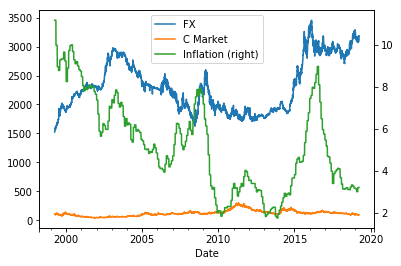

In [6]:
%matplotlib inline
df.plot(kind='line', y=['FX', 'C Market', 'Inflation'], secondary_y='Inflation')

# Part 2

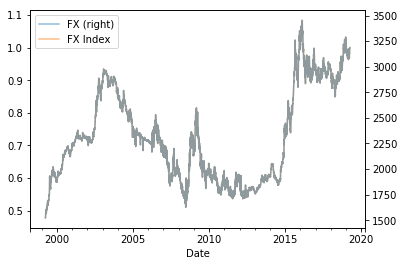

In [7]:
index_date = datetime(2019,3,31)

def index_to_date(date, series):
    index_val = series.loc[date]
    indexed_series = series / index_val
    return indexed_series

df['FX Index'] = index_to_date(index_date, df['FX'])
df.plot(kind='line', y=['FX', 'FX Index'], secondary_y='FX', alpha=.5)

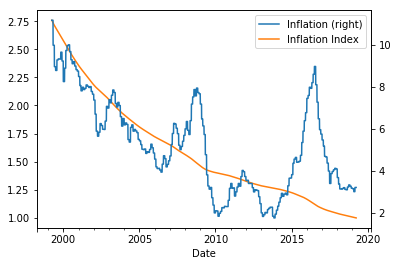

In [8]:
def index_annual_rate_to_date(date, series):
    daily_rate = (1 + series/100) ** (1/365)
    cumulative_rate = daily_rate.sort_index(ascending=False).cumprod()
    return index_to_date(date, cumulative_rate)
    
df['Inflation Index'] = index_annual_rate_to_date(index_date, df['Inflation'])    
df.plot(kind='line', y=['Inflation', 'Inflation Index'], secondary_y='Inflation')

In [14]:
1.05 ** 20

2.653297705144422

In [9]:
# sanity check
print("Quick estimate of 20 years of inflation:", (1 + df['Inflation'].median() / 100) ** 20)
df.head(1)

Quick estimate of 20 years of inflation: 2.658356180725676


,FX,Inflation,C Market,FX Index,Inflation Index
Date,,,,,
1999-04-01,1522.35,11.17,110.05,0.47769,2.758219


In [10]:
df['C Market (Real)'] = df['C Market'] * df['FX Index'] * df['Inflation Index']
df.rename(columns={'C Market': 'C Market (Nominal)'}, inplace=True)

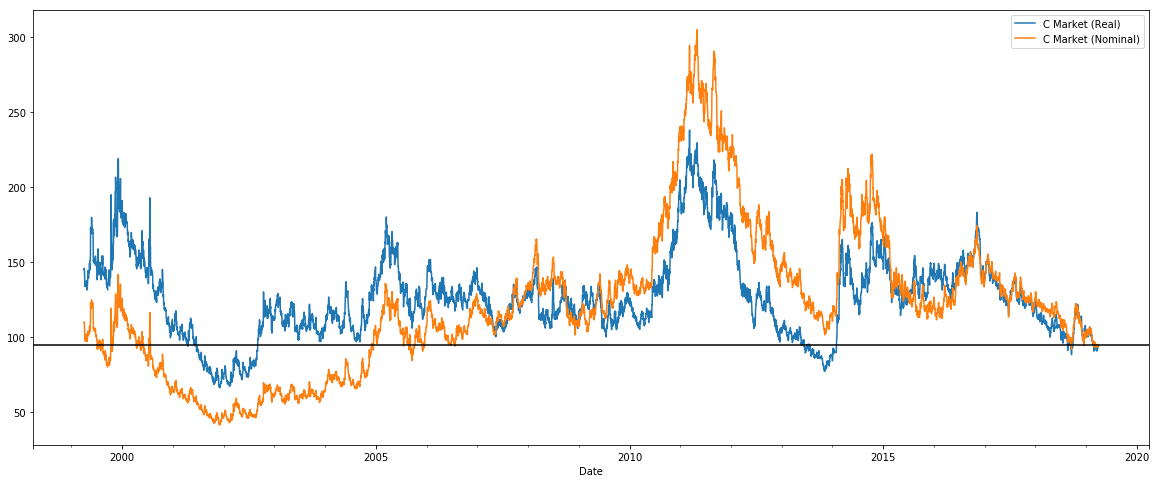

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))

df.plot(kind='line', y=['C Market (Real)', 'C Market (Nominal)'], ax=ax)

current_price = df.iloc[-1]['C Market (Nominal)']
ax.axhline(current_price, color='black')

% of days nominal prices have been below current level 0.24695414099931554


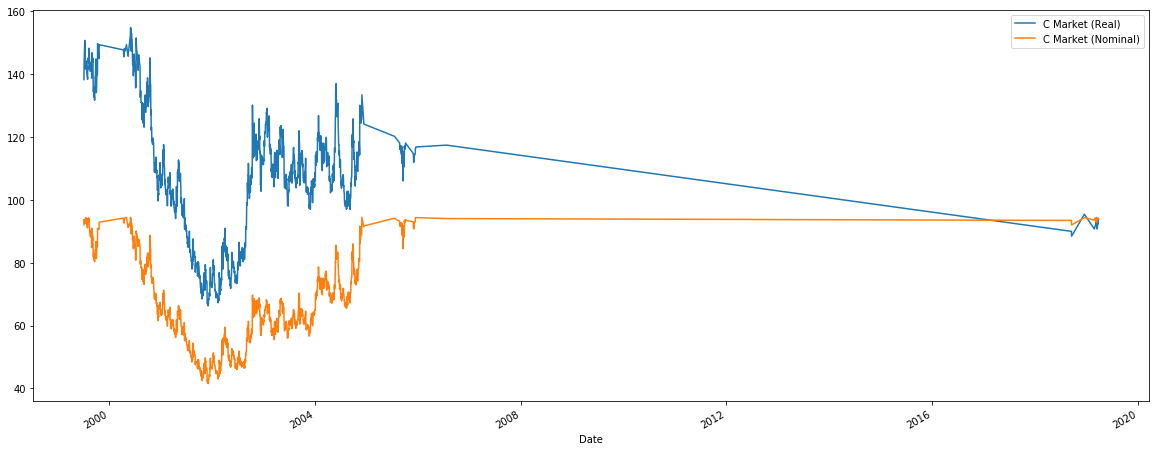

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
df[df['C Market (Nominal)'] < current_price].plot(kind='line', y=['C Market (Real)', 'C Market (Nominal)'], ax=ax)
print("% of days nominal prices have been below current level", (df['C Market (Nominal)'] < current_price).mean())

% of days real prices have been below current level 0.09801505817932922


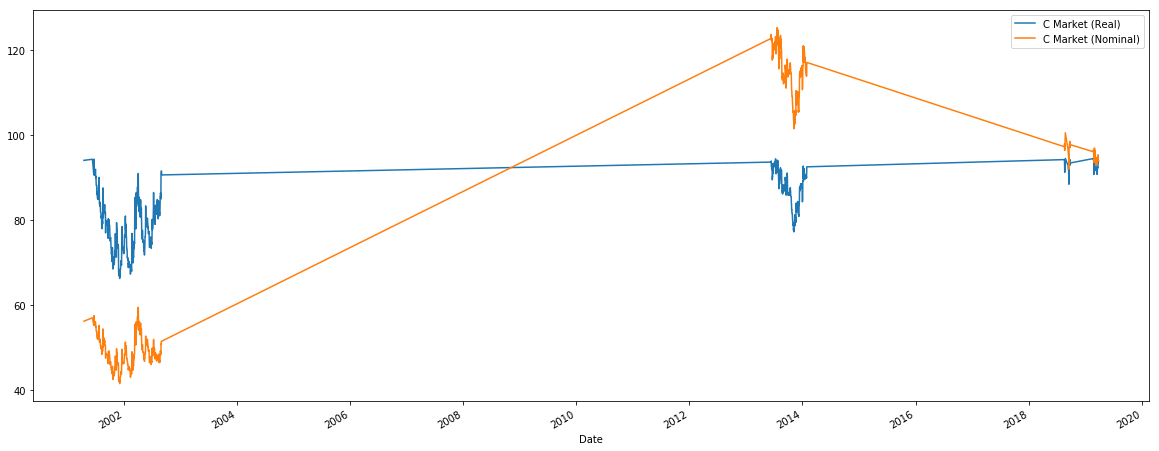

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
df[df['C Market (Real)'] < current_price].plot(kind='line', y=['C Market (Real)', 'C Market (Nominal)'], ax=ax)
print("% of days real prices have been below current level", (df['C Market (Real)'] < current_price).mean())